In [512]:
import numpy as np
from pandas import read_csv
import pandas_datareader.data as web

In [513]:
doge = web.DataReader('MONA-USD', 'yahoo')
doge

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-11-09,3.039360,2.840420,2.855220,2.967630,4630550,2.967630
2017-11-10,2.993850,2.606440,2.959770,2.616590,3069090,2.616590
2017-11-11,2.714720,2.520320,2.627440,2.597220,3258960,2.597220
2017-11-12,3.109670,2.173080,2.598040,2.817210,9822060,2.817210
2017-11-13,3.254420,2.666150,2.795100,2.895720,9818930,2.895720
...,...,...,...,...,...,...
2022-04-18,0.901525,0.878735,0.898389,0.891354,256523,0.891354
2022-04-19,0.896073,0.883590,0.891385,0.889009,151928,0.889009
2022-04-20,0.898475,0.882716,0.889078,0.892699,192726,0.892699


In [514]:
#lstm_data = np.genfromtxt('./sample_data/lstm.csv', delimiter=',', skip_header=True)
lstm_data = read_csv('lstmsmona.csv')
lstm_data = lstm_data.drop(['Date'], axis=1)
print(lstm_data)

        High       Low      Open     Close   Volume  Adj Close  Polarity Score
0   1.241455  1.182781  1.236694  1.184539  1251855   1.184539        0.095867
1   1.197341  1.177413  1.184803  1.184319   696471   1.184319        0.071015
2   1.054188  1.000561  1.016678  1.008785   467346   1.008785        0.146020
3   1.056811  1.008147  1.008871  1.051372   424532   1.051372        0.096342
4   1.060776  1.041301  1.044525  1.055757   490092   1.055757        0.113200
5   1.055742  1.021811  1.055726  1.034679   205570   1.034679        0.367391
6   1.055246  1.022037  1.034578  1.053187   334767   1.053187        0.150535
7   1.060616  1.035437  1.053166  1.049737   234412   1.049737        0.010105
8   1.053838  1.017398  1.049745  1.019293   302457   1.019293        0.232539
9   1.043297  0.999210  1.019312  1.007575   353211   1.007575        0.245144
10  1.016447  0.986993  1.007664  1.006427   271839   1.006427        0.000168
11  1.010323  0.964393  1.006419  0.998416   498230 

In [515]:
lstm_data_X = lstm_data.drop(['Close'], axis=1)
lstm_data_y = lstm_data['Close']

In [516]:
look_back = 5 # how many days to look back
batch_size = 3 # size of batches used when training
n_feat = 6 # number of features 
n_target = 2
n_validation = 6
n_test = 8
n_train = lstm_data_X.shape[0] - n_validation - n_test - 1


In [517]:
n_train

38

In [518]:
#lstm_data_X_train = lstm_data_X.iloc[:30,:]
#lstm_data_X_val = lstm_data_X.iloc[30:40,:]
#lstm_data_X_test = lstm_data_X.iloc[40:52,:]

#lstm_data_y_train = lstm_data_y.iloc[:30]
#lstm_data_y_val = lstm_data_y.iloc[30:40]
#lstm_data_y_test = lstm_data_y.iloc[40:52]
# Convert to numpy arrays
#X_train = lstm_data_X_train.to_numpy()
#X_val = lstm_data_X_val.to_numpy()
#X_test = lstm_data_X_test.to_numpy()
#y_train = lstm_data_y_train.to_numpy()
#y_val = lstm_data_y_val.to_numpy()
#y_test = lstm_data_y_test.to_numpy()

In [519]:
lstm_data_X_train = lstm_data_X.iloc[:n_train,:]
lstm_data_X_val = lstm_data_X.iloc[n_train:n_train + n_validation,:]
lstm_data_X_test = lstm_data_X.iloc[n_train + n_validation:n_train + n_validation + n_test,:]

lstm_data_y_train = lstm_data_y.iloc[:n_train]
lstm_data_y_val = lstm_data_y.iloc[n_train:n_train + n_validation]
lstm_data_y_test = lstm_data_y.iloc[n_train + n_validation:n_train + n_validation + n_test]
# Convert to numpy arrays
X_train = lstm_data_X_train.to_numpy()
X_val = lstm_data_X_val.to_numpy()
X_test = lstm_data_X_test.to_numpy()
y_train = lstm_data_y_train.to_numpy()
y_val = lstm_data_y_val.to_numpy()
y_test = lstm_data_y_test.to_numpy()

In [520]:
X_test

array([[9.26986992e-01, 8.95919025e-01, 9.21091020e-01, 1.80988000e+05,
        8.96641016e-01, 1.67889080e-01],
       [9.09871995e-01, 8.96238029e-01, 8.96736979e-01, 1.74450000e+05,
        9.09659028e-01, 1.15242019e-01],
       [9.15844977e-01, 8.98617029e-01, 9.09632981e-01, 1.57344000e+05,
        9.00707006e-01, 1.31267300e-01],
       [9.10477996e-01, 8.97731006e-01, 9.00560021e-01, 9.41900000e+04,
        8.98356974e-01, 1.29466020e-01],
       [9.01525021e-01, 8.78735006e-01, 8.98388982e-01, 2.56523000e+05,
        8.91354024e-01, 1.41832680e-01],
       [8.96072984e-01, 8.83589983e-01, 8.91385019e-01, 1.51928000e+05,
        8.89008999e-01, 1.41011480e-01],
       [8.98474991e-01, 8.82716000e-01, 8.89078021e-01, 1.92726000e+05,
        8.92699003e-01, 1.27655320e-01],
       [9.02867973e-01, 8.79381001e-01, 8.92624974e-01, 1.67541000e+05,
        8.81784976e-01, 1.31128780e-01]])

In [521]:
y_test

array([0.89664102, 0.90965903, 0.90070701, 0.89835697, 0.89135402,
       0.889009  , 0.892699  , 0.88178498])

In [522]:
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, ThresholdedReLU, MaxPooling2D, Embedding, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [523]:
train_data_gen = TimeseriesGenerator(X_train, y_train, length=look_back, batch_size=batch_size)
val_data_gen = TimeseriesGenerator(X_val, y_val, length=look_back, batch_size=batch_size)
test_data_gen = TimeseriesGenerator(X_test, y_test, length=look_back, batch_size=batch_size)

In [524]:
# check generator dimensions
for i in range(len(train_data_gen)):
    x, y = train_data_gen[i]
    print(x.shape, y.shape)

(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)


In [525]:
model_lstm = Sequential()
model_lstm.add(LSTM(32, input_shape=(look_back, n_feat), return_sequences=True))
model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 5, 32)             4992      
                                                                 
 dropout_48 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_53 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_49 (Dropout)        (None, 32)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13,345
Trainable params: 13,345
Non-trainable params: 0
_________________________________________________________________
None


In [526]:
hist = model_lstm.fit_generator(train_data_gen,
                                        steps_per_epoch=10,
                                        epochs=20,
                                        verbose=1,
                                        validation_data=val_data_gen)

C:\Users\moham\AppData\Local\Temp/ipykernel_24544/192094070.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_lstm.fit_generator(train_data_gen,


Epoch 1/20
10/10 [==============================] - 8s 136ms/step - loss: 0.4999 - mse: 0.4999 - val_loss: 0.0842 - val_mse: 0.0842
Epoch 2/20
10/10 [==============================] - 0s 13ms/step - loss: 0.0473 - mse: 0.0473 - val_loss: 0.0425 - val_mse: 0.0425
Epoch 3/20
10/10 [==============================] - 0s 12ms/step - loss: 0.0478 - mse: 0.0478 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 4/20
10/10 [==============================] - 0s 13ms/step - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 5/20
10/10 [==============================] - 0s 12ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 6.0889e-05 - val_mse: 6.0889e-05
Epoch 6/20
10/10 [==============================] - 0s 11ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 7/20
10/10 [==============================] - 0s 12ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 8/20
10/10 [==============================] - 0s 11ms/step - loss: 0

In [527]:
pred = model_lstm.predict(test_data_gen)

In [528]:
test_data_gen[0]

(array([[[9.26986992e-01, 8.95919025e-01, 9.21091020e-01, 1.80988000e+05,
          8.96641016e-01, 1.67889080e-01],
         [9.09871995e-01, 8.96238029e-01, 8.96736979e-01, 1.74450000e+05,
          9.09659028e-01, 1.15242019e-01],
         [9.15844977e-01, 8.98617029e-01, 9.09632981e-01, 1.57344000e+05,
          9.00707006e-01, 1.31267300e-01],
         [9.10477996e-01, 8.97731006e-01, 9.00560021e-01, 9.41900000e+04,
          8.98356974e-01, 1.29466020e-01],
         [9.01525021e-01, 8.78735006e-01, 8.98388982e-01, 2.56523000e+05,
          8.91354024e-01, 1.41832680e-01]],
 
        [[9.09871995e-01, 8.96238029e-01, 8.96736979e-01, 1.74450000e+05,
          9.09659028e-01, 1.15242019e-01],
         [9.15844977e-01, 8.98617029e-01, 9.09632981e-01, 1.57344000e+05,
          9.00707006e-01, 1.31267300e-01],
         [9.10477996e-01, 8.97731006e-01, 9.00560021e-01, 9.41900000e+04,
          8.98356974e-01, 1.29466020e-01],
         [9.01525021e-01, 8.78735006e-01, 8.98388982e-01, 2.5

In [529]:
pred

array([[0.9581906],
       [0.9581906],
       [0.9581906]], dtype=float32)

In [530]:
import matplotlib.pyplot as plt

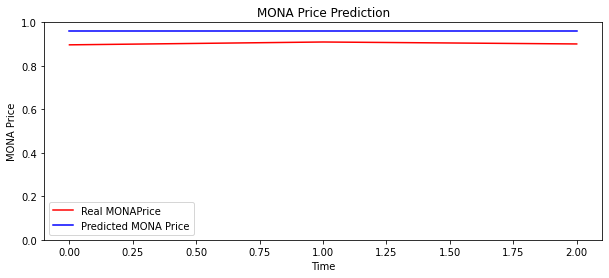

In [531]:
# Visualising the results
plt.figure(figsize=(10,4))
plt.plot(y_test[0:y_test.shape[0]-5], color = 'red', label = 'Real MONAPrice')
plt.plot(pred, color = 'blue', label = 'Predicted MONA Price')
plt.title('MONA Price Prediction')
plt.xlabel('Time')
plt.ylabel('MONA Price')
plt.ylim(0,1)
plt.legend()
plt.show()